In [1]:
#!/usr/bin/env python

import math
import healpy as hp
import numpy as np
import sys
import time
import os

from classy import Class
import PySSC
from scipy.stats import norm
from matplotlib import pyplot as plt

from numcosmo_py import Ncm, Nc

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

In [2]:
cosmo = Nc.HICosmoDEXcdm()
cosmo.props.H0 = 67.81
cosmo.props.Omegac = 0.2612
cosmo.props.Omegab = 0.0486
cosmo.props.Omegax = 1 - 0.0486 - 0.2612
cosmo.props.w = -1.0

reion = Nc.HIReionCamb.new()
prim = Nc.HIPrimPowerLaw.new()

cosmo.add_submodel(reion)
cosmo.add_submodel(prim)

dist = Nc.Distance.new(2.0)

tf = Nc.TransferFunc.new_from_name("NcTransferFuncEH")

psml = Nc.PowspecMLTransfer.new(tf)
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()
prim.props.n_SA = 0.9660
# print(0.82505858,cosmo.sigma8(psf),cosmo.Omega_k0())

old_amplitude = math.exp(prim.props.ln10e10ASA)
prim.props.ln10e10ASA = math.log((0.82505858 / cosmo.sigma8(psf)) ** 2 * old_amplitude)
# print(0.82505858, cosmo.sigma8(psf))

z_obs = Ncm.Vector.new_array(np.linspace(0.1, 0.8, 8))
lnM_obs = Ncm.Vector.new_array(np.linspace(np.log(10) * 14.0, np.log(10) * 15, 2))

print(z_obs.dup_array())
print(lnM_obs.dup_array())
print(prim.props.ln10e10ASA)

[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8]
[32.23619130191664, 34.53877639491069]
3.0274496981616066


# Construct the $S_{ij}$  Matrix

`kernel and masks`

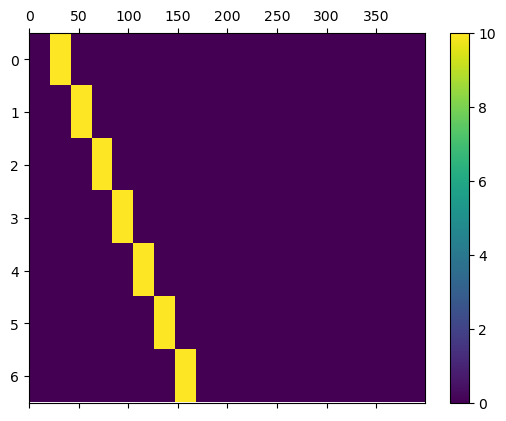

In [3]:
cosmo_fid = Class()
cosmo_fid.set(
    {
        "h": cosmo.props.H0 / 100,
        "Omega_cdm": cosmo.props.Omegac,
        "Omega_b": cosmo.props.Omegab,
        "sigma8": 0.82505858,
        "n_s": 0.9660,
        "output": "mPk",
    }
)
cosmo_fid.compute()
nz = 400
z_arr = np.linspace(0, 1.9, num=nz + 1)[1:]

nbins_T = z_obs.len() - 1

kernels_T = np.zeros((nbins_T, nz))
for i in range(nbins_T):
    zminbin = z_obs.get(i)
    zmaxbin = z_obs.get(i + 1)
    Dz = zmaxbin - zminbin

    for iz in range(nz):
        z = z_arr[iz]
        if (z > zminbin) and (z <= zmaxbin):
            kernels_T[i, iz] = 1 / Dz

fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.matshow(kernels_T)
ax.set_aspect("auto")
plt.colorbar(im)
pass

In [4]:
NSIDE = 2 * 512
NPIX = hp.nside2npix(NSIDE)
m = np.zeros(hp.nside2npix(NSIDE))
pix_theta_ecl, pix_phi_ecl = hp.pix2ang(NSIDE, np.arange(NPIX))

# Guaranteed mask
mask1_guaranteed = np.zeros(NPIX)
mask2_guaranteed = np.zeros(NPIX)
mask3_guaranteed = np.zeros(NPIX)

mask1_guaranteed_condition = (
    (pix_phi_ecl > 3.0 * np.pi / 4.0)
    & (pix_phi_ecl < 13.0 * np.pi / 12.0)
    & (pix_theta_ecl < np.pi / 2.0 - 30.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 80.0 * np.pi / 180)
)
mask2_guaranteed_condition = (
    (pix_phi_ecl > 11.0 * np.pi / 6.0)
    & (pix_theta_ecl < np.pi / 2.0 - 20.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 40.0 * np.pi / 180)
)
mask3_guaranteed_condition = (
    (pix_phi_ecl < np.pi / 4.0)
    & (pix_theta_ecl < np.pi / 2.0 - 20.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 40.0 * np.pi / 180)
)

mask1_guaranteed[mask1_guaranteed_condition] = 1
mask2_guaranteed[mask2_guaranteed_condition] = 1
mask3_guaranteed[mask3_guaranteed_condition] = 1

mask_guaranteed = mask1_guaranteed + mask2_guaranteed + mask3_guaranteed

# Total mask
mask1_full = np.zeros(NPIX)
mask2_full = np.zeros(NPIX)
mask3_full = np.zeros(NPIX)

mask1_full_condition = (
    (pix_phi_ecl > 2.0 * np.pi / 3.0)
    & (pix_phi_ecl < 3.0 * np.pi / 2.0)
    & (pix_theta_ecl < np.pi / 2.0 - 10.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 80.0 * np.pi / 180)
)
mask2_full_condition = (
    (pix_phi_ecl > 11.0 * np.pi / 6.0)
    & (pix_theta_ecl < np.pi / 2.0)
    & (pix_theta_ecl > np.pi / 2.0 - 45.0 * np.pi / 180)
)
mask3_full_condition = (
    (pix_phi_ecl < np.pi / 4.0)
    & (pix_theta_ecl < np.pi / 2.0)
    & (pix_theta_ecl > np.pi / 2.0 - 45.0 * np.pi / 180)
)

mask1_full[mask1_full_condition] = 1
mask2_full[mask2_full_condition] = 1
mask3_full[mask3_full_condition] = 1

mask_full = mask1_full + mask2_full + mask3_full

`S matrices`

In [5]:
# Full sky
t0 = time.time()
S_lacasa = PySSC.Sij(z_arr, kernels_T, cosmo_Class=cosmo_fid)
t1 = time.time()
print("Full sky time (seconds) = " + str(t1 - t0))

S_full = Ncm.Matrix.new(S_lacasa.shape[0], S_lacasa.shape[1])
for i in range(len(S_lacasa)):
    for j in range(len(S_lacasa[i])):
        S_full.set(i, j, S_lacasa[i][j])


# Partial-Sky guaranteed
t0 = time.time()
S_lacasa = PySSC.Sij_psky(z_arr, kernels_T, mask=mask_guaranteed, cosmo_Class=cosmo_fid)
t1 = time.time()
print("Partial sky guaranteed time (seconds) = " + str(t1 - t0))

S_guaranteed = Ncm.Matrix.new(S_lacasa.shape[0], S_lacasa.shape[1])
for i in range(len(S_lacasa)):
    for j in range(len(S_lacasa[i])):
        S_guaranteed.set(i, j, S_lacasa[i][j])


# Partial-Sky maximal
t0 = time.time()
S_lacasa = PySSC.Sij_psky(z_arr, kernels_T, mask=mask_full, cosmo_Class=cosmo_fid)
t1 = time.time()
print("Partial sky maximal time (seconds) = " + str(t1 - t0))

S_maximal = Ncm.Matrix.new(S_lacasa.shape[0], S_lacasa.shape[1])
for i in range(len(S_lacasa)):
    for j in range(len(S_lacasa[i])):
        S_maximal.set(i, j, S_lacasa[i][j])

Full sky time (seconds) = 0.427929162979126
Partial sky guaranteed time (seconds) = 25.136955738067627
Partial sky maximal time (seconds) = 17.19922399520874


# Define proxy modelling

In [6]:
cluster_m = Nc.ClusterMassNodist(lnM_min=np.log(1.0e14), lnM_max=np.log(1.0e16))
cluster_z = Nc.ClusterRedshiftNodist(z_min=0.0, z_max=2.0)

# Initialize the `ClusterAbundance` object

In [7]:
mulf = Nc.MultiplicityFuncTinker.new()
mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta(200.0)

hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hbias_Tinker = Nc.HaloBiasTinker.new(hmf)
cad = Nc.ClusterAbundance.new(hmf, hbias_Tinker)

# Data model

$f(x_i)$ for the Gaussian distribution $$-2\ln L = \sum_{ij}\left[(f(x_i) - y_i)C^{-1}_{ij}(f(x_j) - y_j)\right] + \dots$$

In [8]:
mset = Ncm.MSet.new_array([cosmo, cluster_m, cluster_z])

ncounts_gauss = Nc.DataClusterNCountsGauss.new(cad)
ncounts_gauss.set_size((z_obs.len() - 1) * (lnM_obs.len() - 1))
ncounts_gauss.set_init(True)
ncounts_gauss.use_norma(True)
ncounts_gauss.set_z_obs(z_obs)
ncounts_gauss.set_lnM_obs(lnM_obs)
ncounts_gauss.set_has_ssc(True)
rng = Ncm.RNG.seeded_new(None, 42)

In [9]:
print("Full Sky")

guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)
ncounts_gauss.set_s_matrix(S_full)
ncounts_gauss.resample(mset, rng)
ncounts_gauss.peek_mean().log_vals("y: ", "% 22.15g", True)
ncounts_gauss.peek_cov().log_vals("cov: ", "% 22.15g")

Full Sky
y:       1395.91561627603       3188.81933006884       4912.77082474065       6414.27961666059       7190.94067415305       7419.31165251528       7193.34466370858
cov:        1442.32163000855                      0                      0                      0                      0                      0                      0
cov:                       0        3238.3069335802                      0                      0                      0                      0                      0
cov:                       0                      0       5025.38348907236                      0                      0                      0                      0
cov:                       0                      0                      0       6399.31044955352                      0                      0                      0
cov:                       0                      0                      0                      0       7185.56470369335                      0                

# Creating the fit object and calculating the MCMC

`Full-Sky`

In [10]:
print("Full Sky")

dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset))

mset.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD
)

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)  # 1

sampler = "apes"

nwalkers = int(math.ceil(250))  # 500
ssize = 50000  # 1000000

walker = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset.fparams_len())

esmcmc = Ncm.FitESMCMC.new_funcs_array(
    fit, nwalkers, init_sampler, walker, Ncm.FitRunMsgs.SIMPLE, mfunc_oa
)

esmcmc.set_data_file("mcmc_fullsky.fits")

esmcmc.set_nthreads(4)
t0 = time.time()
esmcmc.start_run()
esmcmc.run(ssize / nwalkers)
# esmcmc.run (10)
# esmcmc.run_lre (50, 1.0e-3)
esmcmc.end_run()
t1 = time.time()

esmcmc.mean_covar()
fit.log_covar()

print("Full sky maximal time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")

Full Sky
0.8250585800000001
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Starting Ensemble Sampler Markov Chain Monte Carlo.
#   Number of walkers: 0250.
#   Number of threads: 0004.
#   Using MPI:         no - use MPI enabled but no slaves available.
# NcmFitESMCMC: No RNG was defined, using algorithm: `mt19937' and seed: 1466701573.


# NcmMSetCatalog: Current mean:   2.1734e+05   0.93794      0.26079     -1            3.1506     
# NcmMSetCatalog: Current msd:    38158        0.02314      0.00062584   0.00062703   0.046136   
# NcmMSetCatalog: Current sd:     6.0334e+05   0.36587      0.0098954    0.0099142    0.72947    
# NcmMSetCatalog: Current var:    3.6401e+11   0.13386      9.7919e-05   9.8291e-05   0.53213    
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Current skfac: -nan         -nan         -nan         -nan         -nan        
# NcmMSetCatalog: Maximal Shrink factor = 1e+10                 
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `1':
# NcmMSetCatalog: Constant break point at `0':
# NcmFitESMCMC:last ensemble variance of -2ln(L):       365328544673.076 (2n = 6), min(-2ln(L)) =       99.0679338798144.
# Tas


(process:37124): NUMCOSMO-WARNING **: 17:12:03.670: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.


`Partial-Sky guaranteed`

In [9]:
print("Partial sky guaranteed")

guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)
ncounts_gauss.set_s_matrix(S_guaranteed)
ncounts_gauss.resample(mset, rng)
ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)


dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset))

mset.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD
)

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)  # 1


sampler = "apes"

nwalkers = int(math.ceil(500))  # 500
ssize = 50000  # 1000000

walker = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset.fparams_len())

esmcmc = Ncm.FitESMCMC.new_funcs_array(
    fit, nwalkers, init_sampler, walker, Ncm.FitRunMsgs.SIMPLE, mfunc_oa
)


esmcmc.set_data_file("mcmc_partialskyguaranteed.fits")

esmcmc.set_nthreads(4)
t0 = time.time()
esmcmc.start_run()
esmcmc.run(ssize / nwalkers)
# esmcmc.run (10)
# esmcmc.run_lre (50, 1.0e-3)
esmcmc.end_run()
t1 = time.time()

esmcmc.mean_covar()
fit.log_covar()

print("Full sky maximal time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")

Partial sky guaranteed
y: 24090.629 59236.016 100211.349 143398.383 180148.206 207808.669 230816.826
0.835039921498831
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Starting Ensemble Sampler Markov Chain Monte Carlo.
#   Number of walkers: 0500.
#   Number of threads: 0004.
#   Using MPI:         no - use MPI enabled but no slaves available.
# NcmFitESMCMC: No RNG was defined, using algorithm: `mt19937' and seed: 2407947344.
# NcmMSetCatalog: Current mean:   58323        0.99564      0.25902     -1.016        3.264      
# NcmMSetCatalog: Current msd:    8798.7       0.017344     0.00045043   0.00043861   0.032981   
# NcmMSetCatalog: Current sd:     1.9674e+05   0.38782      0.010072     0.0098076    0.73747    
# NcmMSetCatalog: Current var:    3.8709e+10   0.1504       0.00010144   9.6188e-05   0.54386    
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Current s


(process:72054): NUMCOSMO-WARNING **: 18:38:21.710: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.


# NcmMSetCatalog: Current mean:   23614        0.94943      0.2579      -1.0165       3.2384     
# NcmMSetCatalog: Current msd:    3031.3       0.0074949    0.00032417   0.00031484   0.014481   
# NcmMSetCatalog: Current sd:     1.174e+05    0.29028      0.012555     0.012194     0.56084    
# NcmMSetCatalog: Current var:    1.3783e+10   0.08426      0.00015763   0.00014869   0.31455    
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Current skfac:  1.0032       1.1308       1.1943       1.1551       1.1408     
# NcmMSetCatalog: Maximal Shrink factor = 1.22447               
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `3':
# NcmMSetCatalog: Constant break point at `0':
# NcmFitESMCMC:acceptance ratio 54.6000% (last update 56.0000%), offboard ratio  0.0000% (last update  0.0000%).
# NcmFitESMCMC


(process:72054): NUMCOSMO-WARNING **: 18:42:41.713: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.

(process:72054): NUMCOSMO-WARNING **: 18:43:07.556: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.


# NcmMSetCatalog: Current mean:   10376        0.87948      0.26227     -1.014        3.0964     
# NcmMSetCatalog: Current msd:    1313.3       0.0034557    0.00025696   0.00029075   0.0072082  
# NcmMSetCatalog: Current sd:     77696        0.20444      0.015202     0.017201     0.42644    
# NcmMSetCatalog: Current var:    6.0366e+09   0.041795     0.0002311    0.00029587   0.18186    
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Current skfac:  0.99934      1.0284       1.1843       1.2009       1.051      
# NcmMSetCatalog: Maximal Shrink factor = 1.21931               
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `7':
# NcmMSetCatalog: Constant break point at `4':
# NcmFitESMCMC:acceptance ratio 40.1333% (last update 12.4000%), offboard ratio  0.0000% (last update  0.0000%).
# NcmFitESMCMC


(process:72054): NUMCOSMO-WARNING **: 18:45:46.747: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.

(process:72054): NUMCOSMO-WARNING **: 18:46:42.987: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.

(process:72054): NUMCOSMO-WARNING **: 18:47:02.605: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.

(process:72054): NUMCOSMO-WARNING **: 18:47:31.856: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.


# NcmMSetCatalog: Current mean:   6701.5       0.85543      0.26471     -1.0114       3.0397     
# NcmMSetCatalog: Current msd:    838.26       0.002278     0.0002158    0.00035564   0.0050508  
# NcmMSetCatalog: Current sd:     62167        0.16894      0.016004     0.026375     0.37457    
# NcmMSetCatalog: Current var:    3.8647e+09   0.028541     0.00025613   0.00069563   0.14031    
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Current skfac:  0.99931      1.026        1.3144       1.2358       1.086      
# NcmMSetCatalog: Maximal Shrink factor = 1.33103               
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `11':
# NcmMSetCatalog: Constant break point at `5':
# NcmFitESMCMC:acceptance ratio 27.2200% (last update  6.0000%), offboard ratio  0.0000% (last update  0.0000%).
# NcmFitESMCM


(process:72054): NUMCOSMO-WARNING **: 18:47:44.590: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.


# NcmMSetCatalog: Current mean:   5709.5       0.84898      0.26534     -1.0102       3.0252     
# NcmMSetCatalog: Current msd:    709.87       0.0019519    0.0002003    0.00035789   0.0044345  
# NcmMSetCatalog: Current sd:     57232        0.15736      0.016148     0.028854     0.35752    
# NcmMSetCatalog: Current var:    3.2755e+09   0.024764     0.00026077   0.00083255   0.12782    
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Current skfac:  0.99935      1.0277       1.3512       1.3017       1.1019     
# NcmMSetCatalog: Maximal Shrink factor = 1.37162               
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `13':
# NcmMSetCatalog: Constant break point at `5':
# NcmFitESMCMC:acceptance ratio 23.9333% (last update  9.4000%), offboard ratio  0.0000% (last update  0.0000%).
# NcmFitESMCM


(process:72054): NUMCOSMO-WARNING **: 18:51:02.937: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.


# NcmMSetCatalog: Current mean:   4980.2       0.84518      0.26556     -1.0095       3.0183     
# NcmMSetCatalog: Current msd:    615.59       0.0017099    0.00018792   0.00035475   0.003978   
# NcmMSetCatalog: Current sd:     53312        0.14808      0.016274     0.030723     0.34451    
# NcmMSetCatalog: Current var:    2.8422e+09   0.021927     0.00026486   0.00094388   0.11869    
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Current skfac:  0.9994       1.0302       1.3668       1.3569       1.1156     
# NcmMSetCatalog: Maximal Shrink factor = 1.39443               
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `15':
# NcmMSetCatalog: Constant break point at `5':
# NcmFitESMCMC:acceptance ratio 21.7000% (last update  9.8000%), offboard ratio  0.0000% (last update  0.0000%).
# NcmFitESMCM


(process:72054): NUMCOSMO-WARNING **: 18:52:05.970: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.

(process:72054): NUMCOSMO-WARNING **: 18:52:50.377: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.


# NcmMSetCatalog: Current mean:   4420.9       0.84274      0.26553     -1.0092       3.0152     
# NcmMSetCatalog: Current msd:    543.42       0.0015234    0.00017769   0.00033177   0.0036252  
# NcmMSetCatalog: Current sd:     50101        0.14045      0.016382     0.030588     0.33423    
# NcmMSetCatalog: Current var:    2.5101e+09   0.019725     0.00026838   0.0009356    0.11171    
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Current skfac:  0.99945      1.0315       1.3622       1.3274       1.1228     
# NcmMSetCatalog: Maximal Shrink factor = 1.38109               
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `17':
# NcmMSetCatalog: Constant break point at `5':
# NcmFitESMCMC:acceptance ratio 20.1500% (last update 12.0000%), offboard ratio  0.0000% (last update  0.0000%).
# NcmFitESMCM


(process:72054): NUMCOSMO-WARNING **: 18:54:01.589: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.


# NcmMSetCatalog: Current mean:   4187.2       0.84205      0.26543     -1.0092       3.0153     
# NcmMSetCatalog: Current msd:    513.33       0.0014452    0.00017334   0.00032238   0.0034775  
# NcmMSetCatalog: Current sd:     48699        0.13711      0.016444     0.030583     0.3299     
# NcmMSetCatalog: Current var:    2.3716e+09   0.018798     0.00027041   0.00093535   0.10884    
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Current skfac:  0.99947      1.0323       1.3594       1.3177       1.1261     
# NcmMSetCatalog: Maximal Shrink factor = 1.376                 
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `18':
# NcmMSetCatalog: Constant break point at `5':
# NcmFitESMCMC:acceptance ratio 19.4824% (last update  8.8000%), offboard ratio  0.0000% (last update  0.0000%).
# NcmFitESMCM


(process:72054): NUMCOSMO-WARNING **: 18:57:02.019: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.

(process:72054): NUMCOSMO-WARNING **: 18:57:15.772: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.

(process:72054): NUMCOSMO-WARNING **: 18:57:22.007: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.

(process:72054): NUMCOSMO-WARNING **: 18:57:22.042: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.


# NcmMSetCatalog: Current mean:   3617.9       0.84044      0.26509     -1.0094       3.016      
# NcmMSetCatalog: Current msd:    440.2        0.0012537    0.0001618    0.00030149   0.0031071  
# NcmMSetCatalog: Current sd:     45107        0.12846      0.016579     0.030894     0.31838    
# NcmMSetCatalog: Current var:    2.0347e+09   0.016503     0.00027487   0.00095441   0.10137    
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Current skfac:  0.99953      1.0345       1.3458       1.2998       1.1339     
# NcmMSetCatalog: Maximal Shrink factor = 1.36047               
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `21':
# NcmMSetCatalog: Constant break point at `5':
# NcmFitESMCMC:acceptance ratio 17.9400% (last update  9.2000%), offboard ratio  0.0000% (last update  0.0000%).
# NcmFitESMCM


(process:72054): NUMCOSMO-WARNING **: 18:59:23.465: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.


# NcmMSetCatalog: Current mean:   3066.9       0.84128      0.26388     -1.0092       3.0288     
# NcmMSetCatalog: Current msd:    369.94       0.0010679    0.00015005   0.00028402   0.0027504  
# NcmMSetCatalog: Current sd:     41361        0.11939      0.016776     0.031754     0.3075     
# NcmMSetCatalog: Current var:    1.7107e+09   0.014254     0.00028143   0.0010083    0.094556   
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Current skfac:  0.99959      1.0352       1.2849       1.2721       1.1272     
# NcmMSetCatalog: Maximal Shrink factor = 1.28795               
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `25':
# NcmMSetCatalog: Constant break point at `5':
# NcmFitESMCMC:acceptance ratio 16.9083% (last update  7.6000%), offboard ratio  0.0000% (last update  0.0000%).
# NcmFitESMCM


(process:72054): NUMCOSMO-WARNING **: 19:04:50.858: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.


# NcmMSetCatalog: Current mean:   2582.5       0.84254      0.26255     -1.0089       3.0433     
# NcmMSetCatalog: Current msd:    308.41       0.00090263   0.00013608   0.00027182   0.0024093  
# NcmMSetCatalog: Current sd:     37772        0.11055      0.016666     0.033291     0.29507    
# NcmMSetCatalog: Current var:    1.4267e+09   0.012221     0.00027775   0.0011083    0.087069   
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Current skfac:  0.99965      1.034        1.2278       1.2567       1.1143     
# NcmMSetCatalog: Maximal Shrink factor = 1.26104               
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `30':
# NcmMSetCatalog: Constant break point at `4':
# NcmFitESMCMC:acceptance ratio 15.2207% (last update  5.2000%), offboard ratio  0.0000% (last update  0.0000%).
# NcmFitESMCM


(process:72054): NUMCOSMO-WARNING **: 19:07:08.093: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.


# NcmMSetCatalog: Current mean:   2504.2       0.84261      0.26237     -1.0089       3.0451     
# NcmMSetCatalog: Current msd:    298.48       0.00087557   0.00013333   0.00026992   0.0023498  
# NcmMSetCatalog: Current sd:     37160        0.10901      0.0166       0.033605     0.29254    
# NcmMSetCatalog: Current var:    1.3809e+09   0.011883     0.00027555   0.0011293    0.085581   
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Current skfac:  0.99966      1.034        1.2222       1.2558       1.1135     
# NcmMSetCatalog: Maximal Shrink factor = 1.25945               
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `31':
# NcmMSetCatalog: Constant break point at `4':
# NcmFitESMCMC:acceptance ratio 14.8800% (last update  5.0000%), offboard ratio  0.0000% (last update  0.0000%).
# NcmFitESMCM


(process:72054): NUMCOSMO-WARNING **: 19:09:16.207: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.

(process:72054): NUMCOSMO-WARNING **: 19:09:42.766: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.


# NcmMSetCatalog: Current mean:   2296.4       0.8428       0.2619      -1.0085       3.05       
# NcmMSetCatalog: Current msd:    272.19       0.00080287   0.0001253    0.00026486   0.0021827  
# NcmMSetCatalog: Current sd:     35489        0.10468      0.016336     0.034534     0.28459    
# NcmMSetCatalog: Current var:    1.2595e+09   0.010958     0.00026688   0.0011926    0.080991   
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Current skfac:  0.99968      1.0342       1.2073       1.2562       1.1109     
# NcmMSetCatalog: Maximal Shrink factor = 1.25866               
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `34':
# NcmMSetCatalog: Constant break point at `4':
# NcmFitESMCMC:acceptance ratio 14.4182% (last update  7.8000%), offboard ratio  0.0000% (last update  0.0000%).
# NcmFitESMCM


(process:72054): NUMCOSMO-WARNING **: 19:12:56.062: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.


# NcmMSetCatalog: Current mean:   2121.7       0.84309      0.26142     -1.0084       3.0549     
# NcmMSetCatalog: Current msd:    250.16       0.00074109   0.00011857   0.00026991   0.0020361  
# NcmMSetCatalog: Current sd:     34025        0.1008       0.016127     0.036712     0.27694    
# NcmMSetCatalog: Current var:    1.1577e+09   0.01016      0.00026007   0.0013478    0.076694   
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Current skfac:  0.9997       1.034        1.19         1.2305       1.1073     
# NcmMSetCatalog: Maximal Shrink factor = 1.23133               
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `37':
# NcmMSetCatalog: Constant break point at `4':
# NcmFitESMCMC:acceptance ratio 13.9167% (last update  8.2000%), offboard ratio  0.0000% (last update  0.0000%).
# NcmFitESMCM


(process:72054): NUMCOSMO-WARNING **: 19:15:56.708: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.


# NcmMSetCatalog: Current mean:   1972.9       0.84327      0.26098     -1.0089       3.0586     
# NcmMSetCatalog: Current msd:    231.42       0.00068798   0.00011278   0.00028425   0.0019062  
# NcmMSetCatalog: Current sd:     32728        0.097295     0.01595      0.040199     0.26958    
# NcmMSetCatalog: Current var:    1.0711e+09   0.0094663    0.00025439   0.001616     0.072675   
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Current skfac:  0.99972      1.0329       1.1728       1.1982       1.1018     
# NcmMSetCatalog: Maximal Shrink factor = 1.19864               
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `40':
# NcmMSetCatalog: Constant break point at `4':
# NcmFitESMCMC:acceptance ratio 13.5590% (last update  7.4000%), offboard ratio  0.0000% (last update  0.0000%).
# NcmFitESMCM


(process:72054): NUMCOSMO-WARNING **: 19:56:41.889: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 5.


# NcmMSetCatalog: Current mean:   1109.2       0.84558      0.25638     -1.0267       3.0847     
# NcmMSetCatalog: Current msd:    123.52       0.00037364   7.3908e-05   0.00041601   0.0010871  
# NcmMSetCatalog: Current sd:     23919        0.072356     0.014312     0.080559     0.21051    
# NcmMSetCatalog: Current var:    5.7212e+08   0.0052354    0.00020484   0.0064898    0.044315   
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Current skfac:  0.99985      1.019        1.0641       1.0392       1.0515     
# NcmMSetCatalog: Maximal Shrink factor = 1.07652               
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `75':
# NcmMSetCatalog: Constant break point at `21':
# NcmFitESMCMC:acceptance ratio 25.2973% (last update 51.0000%), offboard ratio  0.0000% (last update  0.0000%).
# NcmFitESMC


(process:72054): NUMCOSMO-WARNING **: 20:02:10.707: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.


# NcmMSetCatalog: Current mean:   1047.2       0.84573      0.25607     -1.0278       3.0865     
# NcmMSetCatalog: Current msd:    115.8        0.00035082   7.017e-05    0.0004077    0.0010249  
# NcmMSetCatalog: Current sd:     23161        0.070164     0.014034     0.08154      0.20497    
# NcmMSetCatalog: Current var:    5.3642e+08   0.0049229    0.00019695   0.0066488    0.042013   
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Current skfac:  0.99985      1.0178       1.0583       1.0345       1.0478     
# NcmMSetCatalog: Maximal Shrink factor = 1.07051               
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `80':
# NcmMSetCatalog: Constant break point at `21':
# NcmFitESMCMC:acceptance ratio 27.1646% (last update 57.8000%), offboard ratio  0.0000% (last update  0.0000%).
# NcmFitESMC


(process:72054): NUMCOSMO-WARNING **: 20:22:54.708: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.


# NcmMSetCatalog: Current mean:   900.56       0.84612      0.25531     -1.0305       3.0908     
# NcmMSetCatalog: Current msd:    97.531       0.00029679   6.1248e-05   0.00038617   0.00087746 
# NcmMSetCatalog: Current sd:     21256        0.064684     0.013349     0.084164     0.19124    
# NcmMSetCatalog: Current var:    4.5183e+08   0.004184     0.00017818   0.0070835    0.036572   
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Current skfac:  0.99988      1.015        1.0466       1.0284       1.0389     
# NcmMSetCatalog: Maximal Shrink factor = 1.0564                
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `95':
# NcmMSetCatalog: Constant break point at `56':
# NcmFitESMCMC:acceptance ratio 31.6128% (last update 60.8000%), offboard ratio  0.0000% (last update  0.0000%).
# NcmFitESMC


(process:72054): NUMCOSMO-WARNING **: 20:27:06.514: _ncm_data_gauss_cov_prepare_LLT[ncm_matrix_cholesky_decomp]: 1.


# NcmMSetCatalog: Current mean:   876.61       0.84616      0.25518     -1.0311       3.0914     
# NcmMSetCatalog: Current msd:    94.547       0.00028795   5.9787e-05   0.00038231   0.00085314 
# NcmMSetCatalog: Current sd:     20929        0.06374      0.013234     0.084627     0.18885    
# NcmMSetCatalog: Current var:    4.3802e+08   0.0040628    0.00017515   0.0071617    0.035665   
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Current skfac:  0.99988      1.0145       1.0445       1.0272       1.0376     
# NcmMSetCatalog: Maximal Shrink factor = 1.05429               
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `98':
# NcmMSetCatalog: Constant break point at `56':
# NcmFitESMCMC:acceptance ratio 32.3670% (last update 52.6000%), offboard ratio  0.0000% (last update  0.0000%).
# NcmFitESMC

`Partial Sky maximal`

In [10]:
print("Partial Sky maximal area")

maximal_area = 10009.97
cad.set_area(maximal_area * (np.pi / 180) ** 2)
ncounts_gauss.set_s_matrix(S_maximal)
ncounts_gauss.resample(mset, rng)
ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)


dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset))

mset.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD
)

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)  # 1


sampler = "apes"

nwalkers = int(math.ceil(500))  # 500
ssize = 50000  # 1000000

walker = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset.fparams_len())

esmcmc = Ncm.FitESMCMC.new_funcs_array(
    fit, nwalkers, init_sampler, walker, Ncm.FitRunMsgs.SIMPLE, mfunc_oa
)


esmcmc.set_data_file("mcmc_partialskymaximal.fits")

esmcmc.set_nthreads(4)
t0 = time.time()
esmcmc.start_run()
esmcmc.run(ssize / nwalkers)
# esmcmc.run (10)
# esmcmc.run_lre (50, 1.0e-3)
esmcmc.end_run()
t1 = time.time()

esmcmc.mean_covar()
fit.log_covar()

print("Full sky maximal time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")

Partial Sky maximal area
y: 85379.339 204030.586 344022.259 490554.538 615158.399 720801.528 783103.137
0.8470865810460315
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Starting Ensemble Sampler Markov Chain Monte Carlo.
#   Number of walkers: 0500.
#   Number of threads: 0004.
#   Using MPI:         no - use MPI enabled but no slaves available.
# NcmFitESMCMC: No RNG was defined, using algorithm: `mt19937' and seed: 2890341744.
# NcmMSetCatalog: Current mean:   2.2357e+05   0.99436      0.25477     -1.0312       3.29       
# NcmMSetCatalog: Current msd:    28881        0.016305     0.00045702   0.00044876   0.031614   
# NcmMSetCatalog: Current sd:     6.458e+05    0.3646       0.010219     0.010035     0.7069     
# NcmMSetCatalog: Current var:    4.1706e+11   0.13293      0.00010443   0.00010069   0.49971    
# NcmMSetCatalog: Current tau:    1            1            1            1            1          
# NcmMSetCatalog: Curre